# Introduction

Previously, we trained a simple model to predict the probability of having a bomb in the middle of a 5x5 square of the game minesweeper. The problem of this model is that we have to compute a prediction per position. The idea is to convert the previous model to be able to predict the probability all over the border of the game.

When the model will be trained, we will be able to test our bot on games.

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import gc
import gym
import tensorflow as tf

import matplotlib.pyplot as plt

from minesweeper_env.envs.minesweeper_env import MinesweeperEnv
from minesweeper_env.envs.renderer import Renderer

np.set_printoptions(3)

%matplotlib inline

C:\python36\envs\machine_learning\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


# Test the environment

In between this notebook and the previous one, I created an environment closer to gym's requirements with a rendering in pygame. This env + 2 others (2048 & sliding puzzle) are availabel on <a href="https://github.com/Coni63/Personal_envs_gym">github</a>. Let's just test it here

In [3]:
easy = {"width":8, "height":8, "num_mines":10}
medium = {"width":16, "height":16, "num_mines":40}
hard = {"width":16, "height":30, "num_mines":99}

In [4]:
env = gym.make("Mine-v0")
env.env.set_difficulty(**hard)
viewer = Renderer(env.env, show_bomb = True)   # always create the rendered after the difficulty
viewer.start()

In [5]:
for i in range(10):
    env.reset()
    viewer.update()
    while True:
        obs, reward, done, info = env.step(env.env.sample())
        # test_prob = np.random.random(obs.shape)
        # viewer.update(probs = test_prob)
        viewer.update()
        if done:
            print(info)
            break

# viewer.finish()

{'safe_squares': 381, 'exposed_squares': 36, 'num_moves': 5}
{'safe_squares': 381, 'exposed_squares': 14, 'num_moves': 2}
{'safe_squares': 381, 'exposed_squares': 33, 'num_moves': 3}
{'safe_squares': 381, 'exposed_squares': 33, 'num_moves': 2}
{'safe_squares': 381, 'exposed_squares': 9, 'num_moves': 3}
{'safe_squares': 381, 'exposed_squares': 12, 'num_moves': 3}
{'safe_squares': 381, 'exposed_squares': 12, 'num_moves': 6}
{'safe_squares': 381, 'exposed_squares': 16, 'num_moves': 6}
{'safe_squares': 381, 'exposed_squares': 47, 'num_moves': 5}
{'safe_squares': 381, 'exposed_squares': 80, 'num_moves': 17}


In [6]:
viewer.finish()

# Why not Reinforcement Learning

Initially, I wanted to use Reinforcement Learning for this tasks. I was looking for environments  more complex than gym's Box2D but less complex than Atari's one because I don't want to keep the computer run for 3 days prior to get any results.

I didn't applied it for 2 reasons:

<ul>
    <li>
        Main Reason: Minesweeper is a <b>Partially Observable Stochastic Environment</b>. As bombs are randomly placed, we cannot "anticipate" the futur of a move. As a result the discounted reward shoud be 0.
        <ul>
            <li>If we use a DeepQ Network well suited for grid's environement, the Q value will be the possible reward of selecting a specific cell and nothing else. The training will be longer because we can't explore all the position. Even if we only restrict the exploration on borders, we will be in measure of having only 1 observation per iteration. With a supervised model, it's equivalent to have the complete border information.</li>
        </ul>
    </li>
    <li>The reward as I planned it was maybe not the best. I provide 1 reward if I select a cell without bombs but :
        <ul>
            <li>We may clear big areas and the game would be finished with few steps (so with low rewards) and some other games may required a lot more</li>
            <li>I could have provided as reward the percentage of new cleared areas but this is too "random"</li>
        </ul>
    </li>
</ul>

This decided me to do a supervised model. In addtion, this model is more complicated than normal ones so it's a good training for me to learn TensorFlow.

# Model

### Neural Network
Previously the model was quite simple. It was 2 layers of Convolution with a padding "valid" to reduce the 5x5 image to a tensor of 1x1x64. This was flatten and pass through a 3 Dense Layers prior to get the prediction.

Here we want to do the same but we can't do that with a dense layer. To do so, we have to replace the Dense Layers by a Convolutionnal Layer with a Kernel of 1x1. The number of filters will be equivalent to the number of unit in the dense layer. The new model can be represented as :

<img src="model_minesweeper.png"/>

### Pre-processing
For the pre-processing, we can do the same but as we will have a padding Same instead of Valid, we can have only 10 layers. The layer for border is not required.

In addition, we have to find all adjacents cells to a visible area. This can be found by taking the value of the convolution of every cells with a filter of 3x3 filled of 1. If the value is > -8, it's a border.

###  Evaluation
The evaluation on this network will be also more complex. We know which cells are in the border. We will feed this mask to the network and the accuracy/recall/precision, will be computed only on cells in the border. If we use the complete environement, our score will be a lot higher because lots of cells will be visible or hidden but unpredictable so this would highly increase the score for non-relevant information.

In [2]:
def preprocess(grid):
    """
    This function convert the grid to a one-hot encoded matrix of 10 layers
    """
    h, w = grid.shape
    X = np.zeros((h, w, 10), dtype=np.bool)
    for i in range(10):
        X[:, :, i] = (grid == i-1)
    return X

def cells_to_extract(grid):
    """
    This function return all borders positions 
    """
    filter_ = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]], dtype=np.uint8)
    conv_sum = signal.convolve2d(grid, filter_, mode='same', boundary="fill", fillvalue=-1)
    mask = np.logical_and((grid == -1), (conv_sum > -8))
    return np.expand_dims(mask, axis=-1)

In [3]:
class Model:
    def __init__(self, width, height):
        with tf.variable_scope('Input'):
            self.input = tf.placeholder(tf.bool, shape=(None, height, width, 10), name="input_placeholder")
            self.x = tf.cast(self.input, tf.float32)
        
        with tf.variable_scope('Model'):
            self.c1 = tf.layers.conv2d(self.x, filters=128, name="C1",
                                       kernel_size=(3, 3), strides=(1, 1), 
                                       padding="same", activation=tf.nn.relu)
            self.c2 = tf.layers.conv2d(self.c1, filters=64, name="C2",
                                       kernel_size=(3, 3), strides=(1, 1), 
                                       padding="same", activation=tf.nn.relu)
            self.c3 = tf.layers.conv2d(self.c2, filters=64, name="C3",
                                       kernel_size=(1, 1), strides=(1, 1), 
                                       padding="same", activation=tf.nn.relu)
            self.c4 = tf.layers.conv2d(self.c3, filters=64, name="C4",
                                       kernel_size=(1, 1), strides=(1, 1), 
                                       padding="same", activation=tf.nn.relu)
            self.probs = tf.layers.conv2d(self.c4, filters=1, name="C5",
                                          kernel_size=(1, 1), strides=(1, 1), 
                                          padding="same", activation=tf.nn.sigmoid)
        
        with tf.variable_scope('Label'):
            self.y_true = tf.placeholder(tf.bool, shape=(None, height, width, 1), name="label_placeholder")
            self.y_true2 = tf.cast(self.y_true, tf.float32)

        with tf.variable_scope('Masks'):
            self.mask = tf.placeholder(tf.bool, shape=(None, height, width, 1), name="mask_placeholder")
            self.mask2 = tf.cast(self.mask, tf.float32)
        
        with tf.variable_scope('Mask_application'):
            self.y_pred = tf.multiply(self.probs, self.mask2)
            self.y_pred_masked = tf.boolean_mask(self.probs, self.mask)
            self.y_true_masked = tf.boolean_mask(self.y_true2, self.mask)
            self.y_pred_masked_rounded = tf.round(self.y_pred_masked)
        
        with tf.variable_scope('Loss/Scoring'):
            self.Xentropy = tf.losses.sigmoid_cross_entropy(multi_class_labels = self.y_true_masked, logits = self.y_pred_masked)
            self.loss = tf.reduce_mean(self.Xentropy)
            _, self.recall = tf.metrics.recall(labels = self.y_true_masked, predictions = self.y_pred_masked_rounded)
            _, self.precision = tf.metrics.precision(labels = self.y_true_masked, predictions = self.y_pred_masked_rounded)
            _, self.acc = tf.metrics.accuracy(labels = self.y_true_masked, predictions = self.y_pred_masked_rounded)
        
        with tf.variable_scope('Optimization'):
            self.optimizer = tf.train.AdamOptimizer(0.001)
            self.train_ops = self.optimizer.minimize(self.Xentropy)
                
        with tf.variable_scope('Summary'):
            self.score = tf.placeholder(tf.float32, shape=(None))
            self.duration = tf.placeholder(tf.float32, shape=(None))
            self.score_summary = tf.summary.scalar("score", self.score)
            self.duration_summary = tf.summary.scalar("duration", self.duration)
            self.recall_summary = tf.summary.scalar("recall", self.recall)
            self.precision_summary = tf.summary.scalar("precision", self.precision)
            self.accuracy_summary = tf.summary.scalar("accuracy", self.acc)
            self.merged = tf.summary.merge_all()
        
        self.init_g = tf.global_variables_initializer()
        self.init_l = tf.local_variables_initializer()
        
        self.saver = tf.train.Saver()
        
        gc.collect()

Now let's train the Model. We will do it on the "easy" configuration to have a faster training and already a Proof of Concept

In [13]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

easy = {"width":8, "height":8, "num_mines":10}
medium = {"width":16, "height":16, "num_mines":40}
hard = {"width":16, "height":30, "num_mines":99}

diff = easy
h, w = diff["height"], diff["width"]

env = gym.make("Mine-v0")
env.env.set_difficulty(**diff)

mdl = Model(width = w, height = h)

config=tf.ConfigProto(device_count={"GPU": 0, "CPU": 1})

result = {
    "iter" : [],
    "acc" : [],
    "recall": [],
    "precision" : []
}

game_result = []

with tf.Session(config=config) as sess:
    mdl.init_g.run()
    mdl.init_l.run()
    summary_writer = tf.summary.FileWriter("F:/training_data/Minesweeper/log/", graph=tf.get_default_graph())
    game = 0
    done = True
    total_frames = 100000
    for i in range(total_frames):
        if done:
            game += 1
            obs = env.reset()
            obs, reward, done, info = env.step(env.env.sample())
        else:
            obs = new_obs
        X = preprocess(obs)
        mask = cells_to_extract(obs)
        y = np.expand_dims(env.env.bombs, axis=-1)
        _, pred, loss, recall, precision, acc, a, b = sess.run([
                                                                mdl.train_ops, 
                                                                mdl.y_pred, 
                                                                mdl.loss, 
                                                                mdl.recall, 
                                                                mdl.precision, 
                                                                mdl.acc,
                                                                mdl.y_pred_masked,
                                                                mdl.y_true_masked
                                                                ],
                                                        feed_dict={
                                                            mdl.input: np.expand_dims(X, axis=0),
                                                            mdl.y_true: np.expand_dims(y, axis=0),
                                                            mdl.mask: np.expand_dims(mask, axis=0)
                                                        })
        print("Iter : {} \t Loss : {:.3f}\tRecall : {:.3f} - Precision : {:.3f} - Acc : {:.3f}".format(i, loss, recall, precision, acc), end="\r")
        
        result["iter"].append(i)
        result["acc"].append(acc)
        result["recall"].append(recall)
        result["precision"].append(precision)
        
        pred_flat = pred.reshape(h, w)
        lower = np.min(pred_flat[mask[:, :, 0]])
        best_pos = np.argwhere(np.logical_and(pred_flat == lower, mask[:, :, 0]))
        idx = np.random.randint(len(best_pos))
        new_obs, reward, done, info = env.step(best_pos[idx])
        if done:
              game_result.append(info)
#             summ = sess.run(mdl.merged, feed_dict={
#                 mdl.score: info["exposed_squares"]/info["safe_squares"],
#                 mdl.duration: info["num_moves"],
#                 mdl.input: np.expand_dims(X, axis=0),
#                 mdl.y_true: np.expand_dims(y, axis=0),
#                 mdl.mask: np.expand_dims(mask, axis=0)
#             })
#             summary_writer.add_summary(summ, game)
#             if game % 10 == 9:
#                 summary_writer.flush()
#                 print("{}/{}\tGame {}".format(i, total_frames, game), end="\r")
#         
#         if i % 1000 == 999:
#             mdl.saver.save(sess, "F:/training_data/Minesweeper/model.ckpt", global_step=i)

    mdl.saver.save(sess, "F:/training_data/Minesweeper/model.ckpt")

C:\python36\envs\machine_learning\lib\site-packages\tensorflow\python\ops\gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [15]:
gc.collect()

65957

I used tensorboard for the implementation (I didn't succeed to build the model at the first trial :) ). but I still saved results and I'll just save them as csv to explore it after.

In [15]:
res = pd.DataFrame(result)
res = res.set_index("iter")
res.to_csv("F:/data/minesweeper/result.csv")

In [19]:
res2 = pd.DataFrame(game_result)
res2.to_csv("F:/data/minesweeper/game_result.csv")

# Result

Now we trained the models and we can plot the result of metrics followed during the training. I didn't used only Accuracy because it's not the most important one here. In fact, our interest is more on Recall. As a reminder :

\begin{align}
Precision &= \frac{Predicted\: Bomb\: where\: Bomb}{Predicted\: Bomb\: where\: Bomb + Predicted\: Bomb\: where\: not\: Bomb} \\
Recall &= \frac{Predicted\: Bomb\: where\: Bomb}{Predicted\: Bomb\: where\: Bomb + Predicted\: Not\: Bomb\: where\: Bomb} \\
Accuracy &= \frac{Predicted\: Bomb\: where\: Bomb + Predicted\: Not\: Bomb\: where\: Not\: Bomb}{Total\: Predictions}
\end{align}

The recall is more important because a predicting no bombs where there is one would lead to a party lost. The precision is also important because we still need to predict areas with no bombs to be able to play. If we predict a bomb on each cell, we have a good recall but no way to play. The accuracy is just a good indicator but that's all.

### Training results

In [3]:
res = pd.read_csv("F:/data/minesweeper/result.csv", index_col=0)
res.head()

,acc,precision,recall
iter,,,
0,0.416667,0.0,0.0
1,0.481481,0.0,0.0
2,0.526316,0.0,0.0
3,0.568627,0.0,0.0
4,0.597015,0.0,0.0


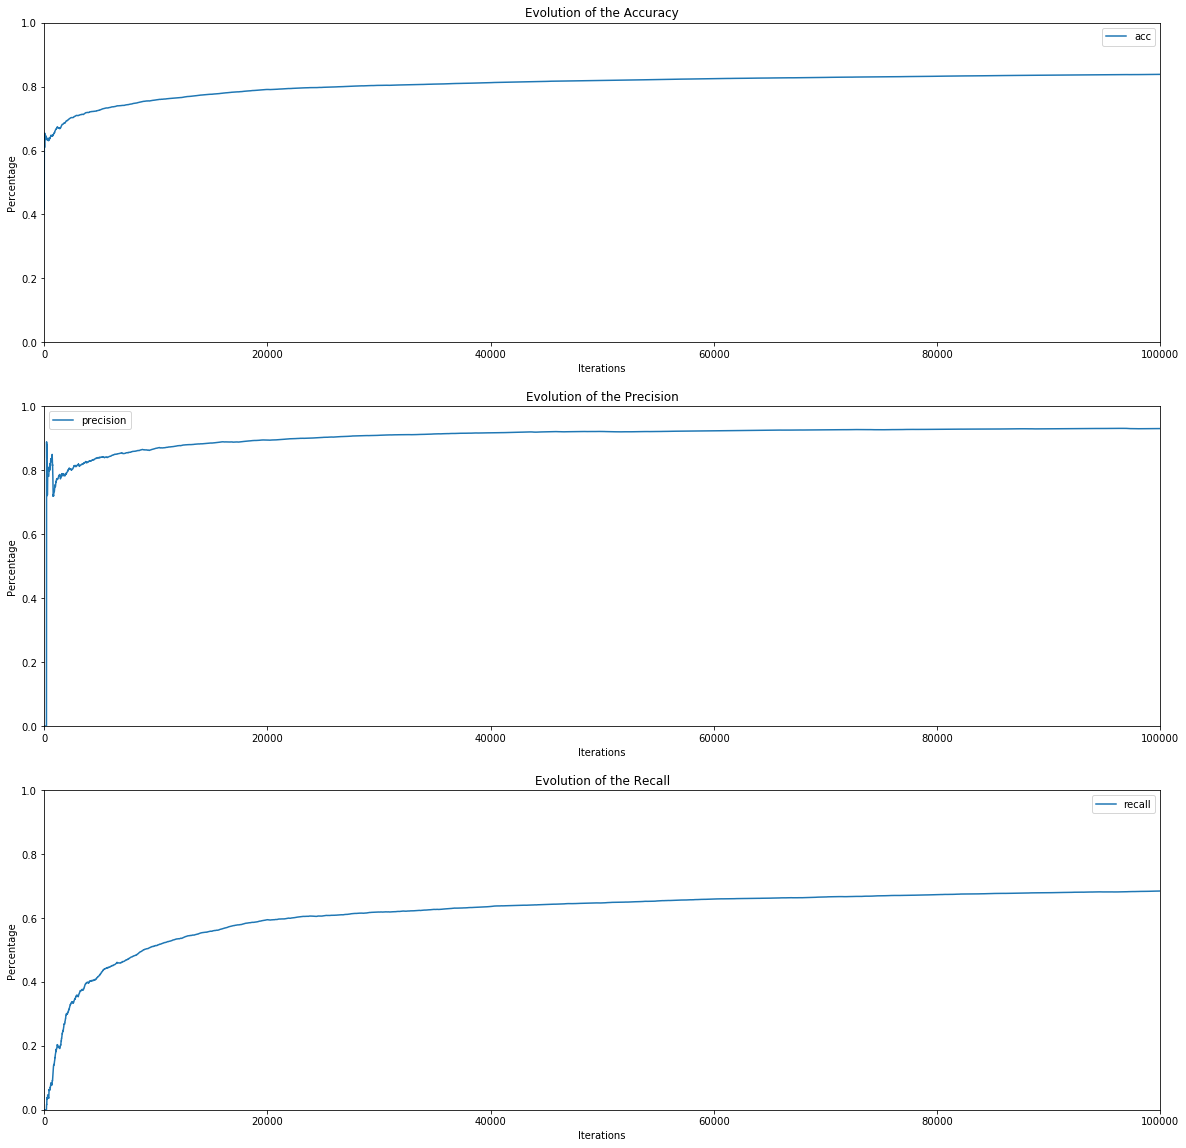

In [6]:
fig, axes =plt.subplots(3, 1, figsize=(20,20))
res.plot(y="acc", ax=axes[0])
res.plot(y="precision", ax=axes[1])
res.plot(y="recall", ax=axes[2])
axes[0].set_ylabel("Percentage")
axes[1].set_ylabel("Percentage")
axes[2].set_ylabel("Percentage")
axes[0].set_xlabel("Iterations")
axes[1].set_xlabel("Iterations")
axes[2].set_xlabel("Iterations")
axes[0].set_title("Evolution of the Accuracy")
axes[1].set_title("Evolution of the Precision")
axes[2].set_title("Evolution of the Recall")
axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)
axes[2].set_ylim(0, 1)
plt.show()

We can see that the accuracy reaches the same level as our previous model using extracted squares. Nevertheless, our recall is quite low. Il 40 % of cases, we will predict no bombs where the is one and ends the game.
Let's nor have a look at game result during training

### Games results

In [9]:
df = pd.read_csv("F:/data/minesweeper/game_result.csv", index_col=0)
df["ratio"] = df["exposed_squares"]/df["safe_squares"]
df["win"] = df["exposed_squares"] == df["safe_squares"]
df.head()

,exposed_squares,num_moves,safe_squares,ratio,win
0,10,2,54,0.185185,False
1,22,2,54,0.407407,False
2,33,15,54,0.611111,False
3,35,6,54,0.648148,False
4,10,2,54,0.185185,False


We can look at the distribution of the ratio of the board visible when the games ends for a batch of 259 all along the training

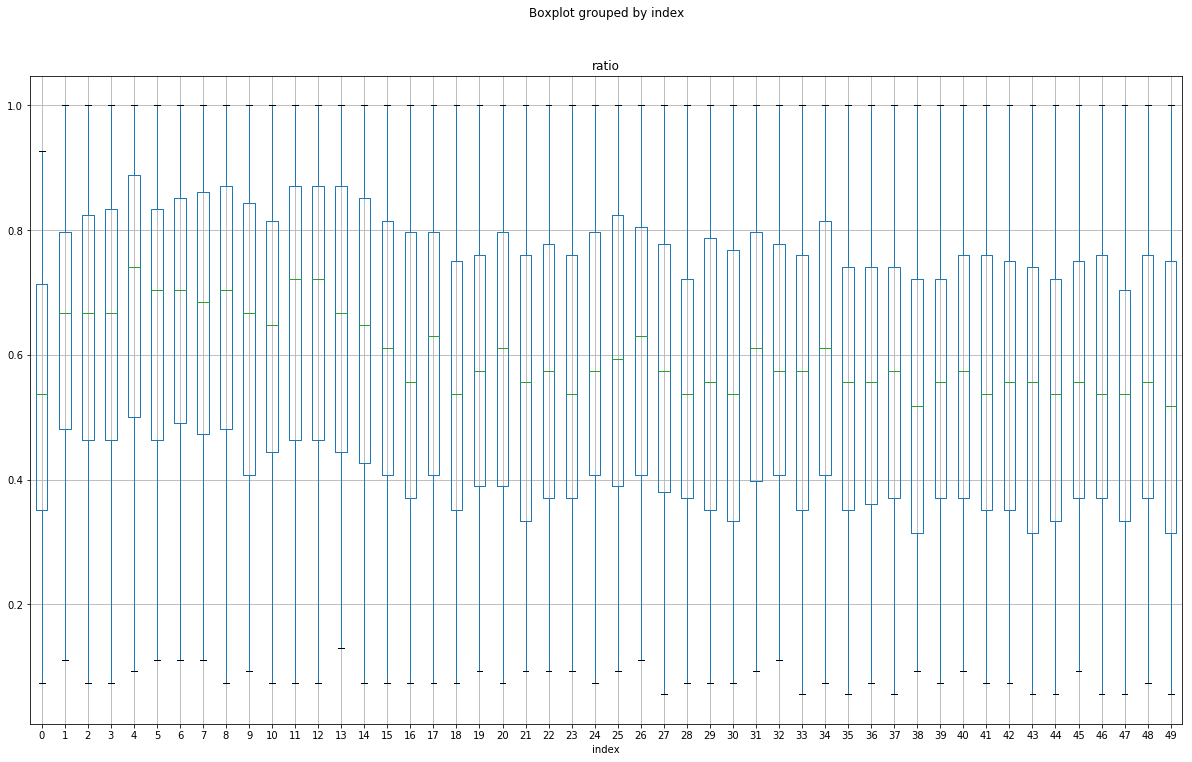

In [148]:
df3 = df.copy().reset_index()
df3["index"] //= 259

fig, ax = plt.subplots(figsize=(20,12))
df3.boxplot(column='ratio',by='index', ax=ax)
plt.show()

We can see that the spreaed is huge. Even if we saw an increase of the ratio between step 4 and 15, it decreased after and is not a lot better than random. We also can group the dataframe by 100 rows to plot the average score / number of moves

In [11]:
df2 = df.groupby(by=lambda x: x//100, axis=0).mean()
df2.head()

,exposed_squares,num_moves,safe_squares,ratio,win
0,30.09,5.73,54.0,0.557222,0.00
1,27.00,5.89,54.0,0.500000,0.00
2,29.06,7.06,54.0,0.538148,0.00
3,35.42,9.50,54.0,0.655926,0.00
4,33.73,9.74,54.0,0.624630,0.02


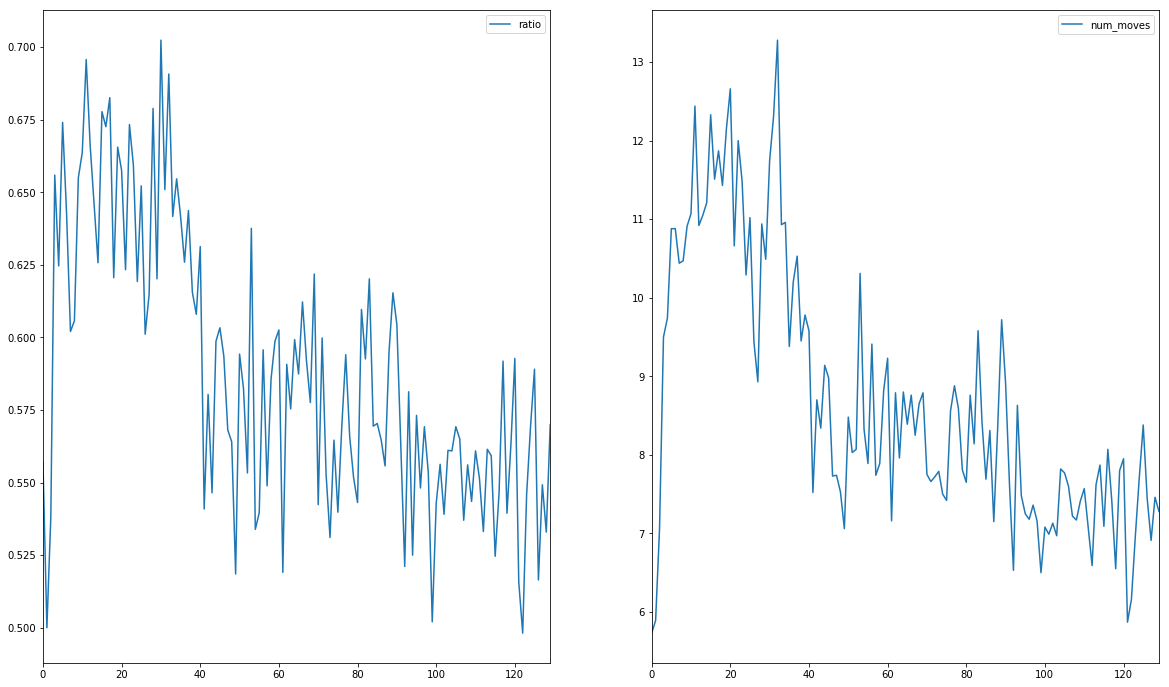

In [12]:
fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(20,12))
df2.plot(x=None, y="ratio", ax=ax1)
df2.plot(x=None, y="num_moves", ax=ax2)
plt.show()

We can see more clearly the decrease of performances after 35x100 iterations. If we stopped the training at this level we would have :

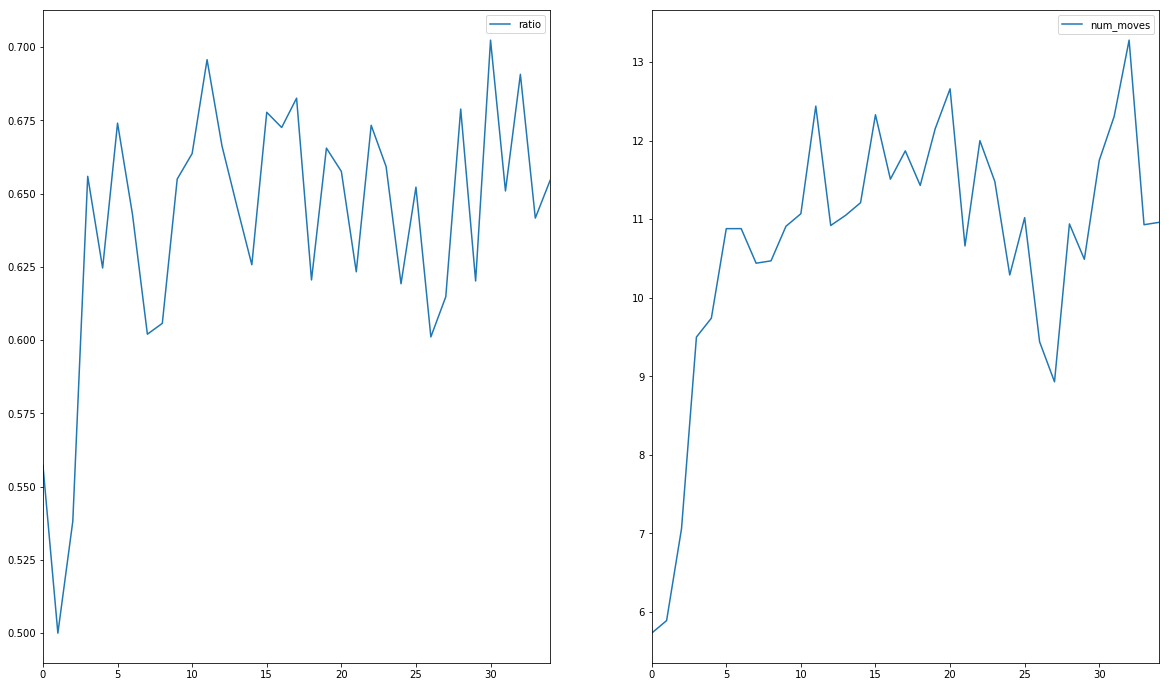

In [151]:
fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(20,12))
df2.iloc[:35].plot(x=None, y="ratio", ax=ax1)
df2.iloc[:35].plot(x=None, y="num_moves", ax=ax2)
plt.show()

By luck, we can reapeat exactly the training as we are running on CPU with seeds for every libraries. So we will used the model trained on 100 000iterations but also one with 3500 steps. Let's train and save both

In [154]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

easy = {"width":8, "height":8, "num_mines":10}
medium = {"width":16, "height":16, "num_mines":40}
hard = {"width":16, "height":30, "num_mines":99}

diff = easy
h, w = diff["height"], diff["width"]

env = gym.make("Mine-v0")
env.env.set_difficulty(**diff)

mdl = Model(width = w, height = h)

config=tf.ConfigProto(device_count={"GPU": 0, "CPU": 1})

result = {
    "iter" : [],
    "acc" : [],
    "recall": [],
    "precision" : []
}

game_result = []

with tf.Session(config=config) as sess:
    mdl.init_g.run()
    mdl.init_l.run()
    summary_writer = tf.summary.FileWriter("F:/training_data/Minesweeper/log/", graph=tf.get_default_graph())
    game = 0
    done = True
    total_frames = 100000
    for i in range(total_frames):
        if done:
            if game == 3500:
                break
            game += 1
            obs = env.reset()
            obs, reward, done, info = env.step(env.env.sample())
        else:
            obs = new_obs
        X = preprocess(obs)
        mask = cells_to_extract(obs)
        y = np.expand_dims(env.env.bombs, axis=-1)
        _, pred, loss, recall, precision, acc, a, b = sess.run([
                                                                mdl.train_ops, 
                                                                mdl.y_pred, 
                                                                mdl.loss, 
                                                                mdl.recall, 
                                                                mdl.precision, 
                                                                mdl.acc,
                                                                mdl.y_pred_masked,
                                                                mdl.y_true_masked
                                                                ],
                                                        feed_dict={
                                                            mdl.input: np.expand_dims(X, axis=0),
                                                            mdl.y_true: np.expand_dims(y, axis=0),
                                                            mdl.mask: np.expand_dims(mask, axis=0)
                                                        })
        print("Iter : {} \t Loss : {:.3f}\tRecall : {:.3f} - Precision : {:.3f} - Acc : {:.3f}".format(i, loss, recall, precision, acc), end="\r")
        
        result["iter"].append(i)
        result["acc"].append(acc)
        result["recall"].append(recall)
        result["precision"].append(precision)
        
        pred_flat = pred.reshape(h, w)
        lower = np.min(pred_flat[mask[:, :, 0]])
        best_pos = np.argwhere(np.logical_and(pred_flat == lower, mask[:, :, 0]))
        idx = np.random.randint(len(best_pos))
        new_obs, reward, done, info = env.step(best_pos[idx])
        if done:
              game_result.append(info)
#             summ = sess.run(mdl.merged, feed_dict={
#                 mdl.score: info["exposed_squares"]/info["safe_squares"],
#                 mdl.duration: info["num_moves"],
#                 mdl.input: np.expand_dims(X, axis=0),
#                 mdl.y_true: np.expand_dims(y, axis=0),
#                 mdl.mask: np.expand_dims(mask, axis=0)
#             })
#             summary_writer.add_summary(summ, game)
#             if game % 10 == 9:
#                 summary_writer.flush()
#                 print("{}/{}\tGame {}".format(i, total_frames, game), end="\r")
#         
#         if i % 1000 == 999:
#             mdl.saver.save(sess, "F:/training_data/Minesweeper/model.ckpt", global_step=i)

    mdl.saver.save(sess, "F:/training_data/Minesweeper/model_2.ckpt")

C:\python36\envs\machine_learning\lib\site-packages\tensorflow\python\ops\gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Now we have our 2 models, we can simulated let say 1000 games with a random agent, the model trained on 100k iteration and the one with 3500 iterations to see the difference.

# Simulation

### Random Games

In [27]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

easy = {"width":8, "height":8, "num_mines":10}
medium = {"width":16, "height":16, "num_mines":40}
hard = {"width":16, "height":30, "num_mines":99}

diff = easy
h, w = diff["height"], diff["width"]

env = gym.make("Mine-v0")
env.env.set_difficulty(**diff)

result_random = []

for i in range(1000):
    obs = env.reset()
    obs, reward, done, info = env.step(env.env.sample())
    while True:
        X = preprocess(obs)
        mask = cells_to_extract(obs)
        list_pos = np.argwhere(mask[:, :, 0])
        idx = np.random.randint(len(list_pos))
        obs, reward, done, info = env.step(list_pos[idx])
        if done:
            result_random.append(info)
            break

### Trained Model (100 000 iterations)

In [157]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

easy = {"width":8, "height":8, "num_mines":10}
medium = {"width":16, "height":16, "num_mines":40}
hard = {"width":16, "height":30, "num_mines":99}

diff = easy
h, w = diff["height"], diff["width"]

env = gym.make("Mine-v0")
env.env.set_difficulty(**diff)

mdl2 = Model(width = w, height = h)

config=tf.ConfigProto(device_count={"GPU": 0, "CPU": 1})

result_trained = []

with tf.Session(config=config) as sess:
    mdl2.saver.restore(sess, "F:/training_data/Minesweeper/model.ckpt")
    for i in range(1000):
        obs = env.reset()
        new_obs, reward, done, info = env.step(env.env.sample())
        while True:
            obs = new_obs
            X = preprocess(obs)
            mask = cells_to_extract(obs)
            pred = sess.run([mdl2.y_pred],
                            feed_dict={
                                mdl2.input: np.expand_dims(X, axis=0),
                                mdl2.mask: np.expand_dims(mask, axis=0)
                            })
            pred_flat = pred[0].reshape(h, w)
            pred_flat[ mask[:, :, 0] == False ] = 2
            best_pos = np.argwhere(pred_flat == np.min(pred_flat))
            idx = np.random.randint(len(best_pos))
            new_obs, reward, done, info = env.step(best_pos[idx])
            if done:
                result_trained.append(info)
                break

C:\python36\envs\machine_learning\lib\site-packages\tensorflow\python\ops\gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from F:/training_data/Minesweeper/model.ckpt


### Trained Model (3 500 iterations)

In [5]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

easy = {"width":8, "height":8, "num_mines":10}
medium = {"width":16, "height":16, "num_mines":40}
hard = {"width":16, "height":30, "num_mines":99}

diff = easy
h, w = diff["height"], diff["width"]

env = gym.make("Mine-v0")
env.env.set_difficulty(**diff)

mdl3 = Model(width = w, height = h)

config=tf.ConfigProto(device_count={"GPU": 0, "CPU": 1})

result_trained_v2 = []

with tf.Session(config=config) as sess:
    mdl3.saver.restore(sess, "F:/training_data/Minesweeper/model_2.ckpt")
    for i in range(1000):
        obs = env.reset()
        new_obs, reward, done, info = env.step(env.env.sample())
        while True:
            obs = new_obs
            X = preprocess(obs)
            mask = cells_to_extract(obs)
            pred = sess.run([mdl3.y_pred],
                            feed_dict={
                                mdl3.input: np.expand_dims(X, axis=0),
                                mdl3.mask: np.expand_dims(mask, axis=0)
                            })
            pred_flat = pred[0].reshape(h, w)
            pred_flat[ mask[:, :, 0] == False ] = 2
            best_pos = np.argwhere(pred_flat == np.min(pred_flat))
            idx = np.random.randint(len(best_pos))
            new_obs, reward, done, info = env.step(best_pos[idx])
            if done:
                result_trained_v2.append(info)
                break

C:\python36\envs\machine_learning\lib\site-packages\tensorflow\python\ops\gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from F:/training_data/Minesweeper/model_2.ckpt


And let's process results. We have for each games the number of moves and exposed squares. Knowing that we know the number of squares to have visible to win.

In [16]:
df_random = pd.DataFrame(result_random)
df_trained = pd.DataFrame(result_trained)
df_trained_v2 = pd.DataFrame(result_trained_v2)
df_random.to_csv("F:/data/minesweeper/df_random.csv")
df_trained.to_csv("F:/data/minesweeper/df_trained.csv")
df_trained_v2.to_csv("F:/data/minesweeper/df_trained_v2.csv")

In [15]:
df_random = pd.read_csv("F:/data/minesweeper/df_random.csv", index_col = 0)
df_trained = pd.read_csv("F:/data/minesweeper/df_trained.csv", index_col = 0)
df_trained_v2 = pd.read_csv("F:/data/minesweeper/df_trained_v2.csv", index_col = 0)

In [17]:
df_trained_v2.head()

,exposed_squares,num_moves,safe_squares
0,24,16,54
1,33,2,54
2,44,19,54
3,20,9,54
4,39,6,54


Let's merge those dataframes

In [18]:
df_random.columns = [x+"_random" for x in df_random.columns]
df_trained.columns = [x+"_trained" for x in df_trained.columns]
df_trained_v2.columns = [x+"_trained_v2" for x in df_trained_v2.columns]
final = pd.concat([df_random, df_trained, df_trained_v2], axis=1)
final.rename(columns={'safe_squares_random':'safe_squares'}, inplace=True)
final.drop(["safe_squares_trained", "safe_squares_trained_v2"], axis=1, inplace=True)
final.head()

,exposed_squares_random,num_moves_random,safe_squares,exposed_squares_trained,num_moves_trained,exposed_squares_trained_v2,num_moves_trained_v2
0,10,2,54,15,7,24,16
1,26,6,54,25,4,33,2
2,6,3,54,38,7,44,19
3,33,3,54,30,3,20,9
4,8,2,54,17,4,39,6


we can now compute wins

In [21]:
final["win_random"] = final["exposed_squares_random"]//final["safe_squares"]
final["win_trained"] = final["exposed_squares_trained"]//final["safe_squares"]
final["win_trained_v2"] = final["exposed_squares_trained_v2"]//final["safe_squares"]

and prepare plots

In [22]:
lose_random = final["win_random"].value_counts()[0]
lose_trained = final["win_trained"].value_counts()[0]
lose_trained_v2 = final["win_trained_v2"].value_counts()[0]
global_win = [
                lose_random,
                lose_trained,
                lose_trained_v2,
                len(final)-lose_random,
                len(final)-lose_trained,
                len(final)-lose_trained_v2
             ]

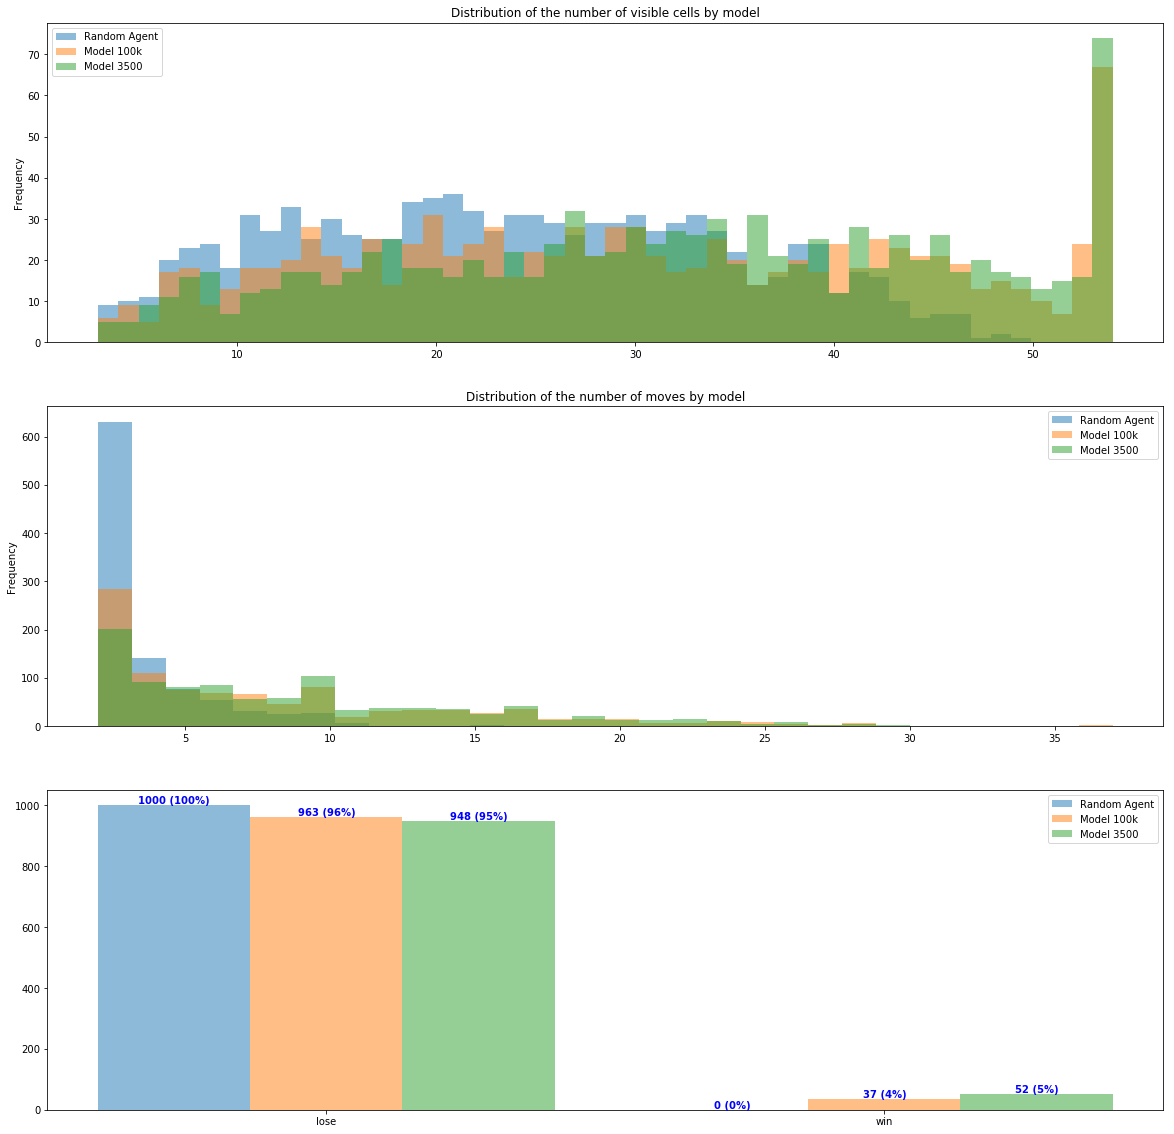

In [27]:
x_pos = [0, 0.3, 0.6, 1.1, 1.4, 1.7]

fig, axes =plt.subplots(3, 1, figsize=(20, 20))
a = final.plot(kind="hist", 
               y=["exposed_squares_random", "exposed_squares_trained", "exposed_squares_trained_v2"], 
               bins=50, 
               alpha=0.5, 
               ax=axes[0],
               title = "Distribution of the number of visible cells by model",
              )
axes[0].legend(["Random Agent", "Model 100k", "Model 3500"]);

final.plot(kind="hist", 
           y=["num_moves_random", "num_moves_trained", "num_moves_trained_v2"], 
           bins=30, 
           alpha=0.5, 
           ax=axes[1],
           title = "Distribution of the number of moves by model",
          )
axes[1].legend(["Random Agent", "Model 100k", "Model 3500"]);

axes[2].bar(x_pos[0::3], global_win[0::3], width=0.3, color="C0", alpha = 0.5)
axes[2].bar(x_pos[1::3], global_win[1::3], width=0.3, color="C1", alpha = 0.5)
axes[2].bar(x_pos[2::3], global_win[2::3], width=0.3, color="C2", alpha = 0.5)
axes[2].set_xticks([0.3, 1.4])
axes[2].set_xticklabels(["lose", "win"])
axes[2].legend(["Random Agent", "Model 100k", "Model 3500"]);
for i, v in enumerate(global_win):
    txt = "{} ({:.0f}%)".format(v, 100*v/len(final))
    axes[2].text(x_pos[i], v + 5, txt, color='blue', fontweight='bold', ha="center")
    
plt.show()

# Conclusion

We can see that the training provides a learning allowing to detect some bombs and go in average a bit further than random click but it's often not enought to finish games (even if we are in simple games where we solve only 5 of games 52/1000). This may be due to the number of filters used and maybe the depth of the model. As it was done in the previous notebook, we only only a square of 5x5 to predict the probability of having a bombs at a given position. A bigger depth would increase this used area. 

Regarding the training, even if indicators are better at 100k iterations, the models works better with 3500 iteration. This is most probably due to overfitting.Some regularizations / dropout may help but I guess having a batch of games too. Currently, the backpropagation is done at every iteration and gradients cannot be averages all along the batch and impacts the learning.

This are leads to follow for a future project.